# Cognitive Memory Agent - Benchmark Demo

**Does episodic/procedural/consolidation memory actually help, or is vanilla RAG enough?**

This notebook runs a structured benchmark comparing two agents:

| Agent | Memory Systems | Purpose |
|-------|---------------|----------|
| **Baseline** (semantic_only) | Working + Semantic (RAG) | Standard retrieval-augmented generation |
| **Full** | Working + Semantic + Episodic + Procedural + Consolidation | Cognitive memory architecture |

All tests use a **5-page synthetic PDF** about a fictional company (Zeltron Corporation). Since Claude has never seen this data in training, correct answers **prove** the memory systems work.

### Sections

| # | Section | What it tests | Expected outcome |
|---|---------|--------------|------------------|
| 1 | **Semantic Retrieval** | 12 factual questions (easy/medium/hard) using RAG over the PDF | Both agents score similarly - episodic memory is irrelevant for pure fact lookup |
| 2 | **Episodic Memory** | 3 multi-turn conversations plant user-specific details, then 4 recall questions ask about them | Full agent recalls conversation history; baseline scores ~0 (no memory of past chats) |
| 3 | **Consolidation** | Overlapping episodes are built, then a sleep phase merges similar ones and promotes rules | Episodes compress, procedural rules grow |
| 4 | **Post-Consolidation Recall** | 2 synthesis questions requiring themes across multiple past conversations | Full agent synthesizes across consolidated memories; baseline cannot |
| 5 | **Integration Demo** | One complex query activates all 5 memory systems, showing each contribution | Full agent produces a personalized response using semantic + episodic + procedural context |
| 6 | **Scorecard** | Side-by-side comparison table + dashboard | Clear gap on episodic/synthesis tasks, parity on semantic tasks |

In [1]:
import os, sys, json, shutil, time, textwrap, re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from IPython.display import display, Markdown, HTML
from dotenv import load_dotenv

# Load API key from .env
load_dotenv()
assert os.environ.get('ANTHROPIC_API_KEY'), 'Set ANTHROPIC_API_KEY in .env or env var before running'

# Clean slate
for path in ['chroma_db', 'procedural_memory.txt']:
    if os.path.isdir(path):
        shutil.rmtree(path)
    elif os.path.isfile(path):
        os.remove(path)

os.makedirs('figures', exist_ok=True)


def show_chat(question, response, label='', agent_name='Agent'):
    """Display a chat exchange with styled HTML."""
    badge = ''
    if label:
        if 'PASS' in label.upper():
            badge_color = '#27ae60'
        elif 'FAIL' in label.upper():
            badge_color = '#e74c3c'
        elif 'PARTIAL' in label.upper():
            badge_color = '#f39c12'
        else:
            badge_color = '#7f8c8d'
        badge = f'<span style="background:{badge_color};color:white;padding:2px 8px;border-radius:4px;font-size:12px;font-weight:bold;">{label}</span> '

    # Escape HTML in response but preserve newlines
    resp_escaped = response.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;')
    resp_html = resp_escaped.replace('\n', '<br>')

    html = f"""
    <div style="margin:10px 0;">
        {badge}
        <div style="border-left:3px solid #3498db;padding:8px 12px;margin:6px 0;background:#f0f7ff;border-radius:0 4px 4px 0;">
            <strong style="color:#2c3e50;">User:</strong> {question}
        </div>
        <div style="border-left:3px solid #27ae60;padding:8px 12px;margin:6px 0;background:#f0fff0;border-radius:0 4px 4px 0;">
            <strong style="color:#2c3e50;">{agent_name}:</strong><br>{resp_html}
        </div>
    </div>
    """
    display(HTML(html))


def show_comparison(question, baseline_resp, full_resp, baseline_pass, full_pass, label=''):
    """Show baseline vs full agent side by side."""
    b_tag = 'PASS' if baseline_pass else 'FAIL'
    f_tag = 'PASS' if full_pass else 'FAIL'
    if label:
        print(f'  [{label}]')
    print(f'  Q: {question}')
    print(f'  Baseline [{b_tag}]: {baseline_resp[:200]}')
    print(f'  Full     [{f_tag}]: {full_resp[:200]}')
    print()

print('Environment ready.')

Environment ready.


---
## 0. Initialize Both Agents

In [2]:
from agent import CognitiveAgent

# Initialize both agents (they share the same ChromaDB for semantic memory)
full_agent = CognitiveAgent(mode='full')
baseline_agent = CognitiveAgent(mode='semantic_only')

print(f'Baseline: {baseline_agent.semantic.collection.count()} chunks | Full: {full_agent.semantic.collection.count()} chunks')


Loading semantic memory (mode=full)...


  Ingested: zeltron_manual.pdf -> 16 chunks


Loading semantic memory (mode=semantic_only)...
  Already ingested: zeltron_manual.pdf (16 chunks)
Baseline: 16 chunks | Full: 16 chunks


---
## 0.5 Knowledge Base: The Zeltron Manual (5 pages)

The PDF contains deliberately planted features for testing:
- **Revenue contradiction**: Page 1 says approx. $89M, Page 4 says $91.2M (including deferred contracts)
- **Cross-references**: Page 2 references Page 5 for benchmarks
- **Version history**: QA-3 -> QA-5 -> QA-7 with dates and specs
- **Multiple competitors**: WaveLogic, NovaSonic, AcoustiQ (not just one)
- **Incident report**: 2024 Reykjavik outage with specific cause
- **Future roadmap**: QA-8 and QA-9 planned

In [3]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader('data/zeltron_manual.pdf')
pages = loader.load()
pdf_text = '\n'.join(p.page_content for p in pages)

# Key facts ground truth
key_facts = {
    'Company': 'Zeltron Corporation, founded 2019, Reykjavik, Iceland',
    'Founders': 'Dr. Maren Solvik (CTO) + Tomas Ekberg (CEO)',
    'Processor': 'QA-7: 847 teraflops, 12,847 barium titanate resonators',
    'Temperature': '22.4C (Solvik Temperature)',
    'RSA result': '2048-bit RSA in 14.7 seconds (ZR-2024-0871)',
    'Language': 'Harmonic (crescendo=for, fermata=conditional, compiles to WaveIR)',
    'Divisions': 'Resonance Engineering, Acoustic Logic, Harmonic Systems',
    'Employees': '342 across Reykjavik (180), Zurich (87), Osaka (75)',
    'Revenue': '$89M base / $91.2M incl. deferred (CONTRADICTION BY DESIGN)',
    'Competitors': 'WaveLogic (203 TF), NovaSonic (89 TF), AcoustiQ (312 TF)',
    'Incident': '2024 Reykjavik: 3h outage, temp reached 22.7C > Solvik 22.4C',
    'Roadmap': 'QA-8 (2025, 1200 TF), QA-9 (2026, 2000+ TF)',
    'Stock': 'ZLTN on Iceland Stock Exchange',
    'Motto': 'In Resonance, Truth',
}

display(Markdown(f'### PDF: {len(pages)} pages, {full_agent.semantic.collection.count()} chunks'))
display(Markdown('### Ground Truth Key Facts'))
facts_md = '\n'.join(f'- **{k}:** {v}' for k, v in key_facts.items())
display(Markdown(facts_md))

### PDF: 5 pages, 16 chunks

### Ground Truth Key Facts

- **Company:** Zeltron Corporation, founded 2019, Reykjavik, Iceland
- **Founders:** Dr. Maren Solvik (CTO) + Tomas Ekberg (CEO)
- **Processor:** QA-7: 847 teraflops, 12,847 barium titanate resonators
- **Temperature:** 22.4C (Solvik Temperature)
- **RSA result:** 2048-bit RSA in 14.7 seconds (ZR-2024-0871)
- **Language:** Harmonic (crescendo=for, fermata=conditional, compiles to WaveIR)
- **Divisions:** Resonance Engineering, Acoustic Logic, Harmonic Systems
- **Employees:** 342 across Reykjavik (180), Zurich (87), Osaka (75)
- **Revenue:** $89M base / $91.2M incl. deferred (CONTRADICTION BY DESIGN)
- **Competitors:** WaveLogic (203 TF), NovaSonic (89 TF), AcoustiQ (312 TF)
- **Incident:** 2024 Reykjavik: 3h outage, temp reached 22.7C > Solvik 22.4C
- **Roadmap:** QA-8 (2025, 1200 TF), QA-9 (2026, 2000+ TF)
- **Stock:** ZLTN on Iceland Stock Exchange
- **Motto:** In Resonance, Truth

---
## 1. Semantic Retrieval Benchmark (Baseline vs Full)

Both agents should score similarly here since these questions only need RAG.

| Difficulty | Tests | What it measures |
|-----------|-------|------------------|
| Easy | Direct fact lookup | Basic retrieval works |
| Medium | Multi-hop / cross-page reasoning | Chunks connect properly |
| Hard | Contradiction detection, hallucination resistance, negation | Agent quality |

In [4]:
semantic_tests = [
    # EASY: Direct lookup
    {
        'question': 'What is the Zeltron stock ticker?',
        'check_contains': ['ZLTN'],
        'difficulty': 'Easy',
        'reasoning': 'Direct fact in the PDF'
    },
    {
        'question': 'How many employees does Zeltron have?',
        'check_contains': ['342'],
        'difficulty': 'Easy',
        'reasoning': 'Direct number from PDF'
    },
    {
        'question': 'When was Zeltron founded and by whom?',
        'check_contains': ['2019', 'Solvik'],
        'difficulty': 'Easy',
        'reasoning': 'Two facts from the same paragraph'
    },
    {
        'question': 'What is the power consumption of the QA-7 at peak load?',
        'check_contains': ['4.1'],
        'difficulty': 'Easy',
        'reasoning': 'Specific spec from Page 2'
    },

    # MEDIUM: Multi-hop / cross-page
    {
        'question': 'What was the teraflops improvement from the QA-5 to the QA-7?',
        'check_contains': ['410', '847'],
        'difficulty': 'Medium',
        'reasoning': 'Must find both version specs and compare'
    },
    {
        'question': 'Which office handles the hardware R&D for the processor that uses barium titanate resonators?',
        'check_contains': ['Osaka'],
        'difficulty': 'Medium',
        'reasoning': 'Must connect: barium titanate -> QA-7 -> Resonance Engineering -> Osaka'
    },
    {
        'question': 'Name all three competitors and their flagship processor teraflops.',
        'check_contains': ['WaveLogic', 'NovaSonic', 'AcoustiQ', '203', '89', '312'],
        'difficulty': 'Medium',
        'reasoning': 'Must combine info from all three competitor entries on Page 5'
    },
    {
        'question': 'How many joint papers has Zeltron published with the University of Reykjavik, and at which venues?',
        'check_contains': ['7', 'IEEE', 'ISCA'],
        'difficulty': 'Medium',
        'reasoning': 'Specific detail from academic collaboration section (Page 3)'
    },

    # HARD: Contradiction, negation, hallucination resistance
    {
        'question': "What is Zeltron's exact 2024 revenue? Be precise.",
        'check_contains': ['89', '91.2'],
        'difficulty': 'Hard',
        'reasoning': 'Should note BOTH figures - $89M (Section 1) and $91.2M (Section 4, incl. deferred)'
    },
    {
        'question': 'What caused the system outage during the NATO demonstration?',
        'check_contains': ['22.7', 'temperature'],
        'difficulty': 'Hard',
        'reasoning': 'Must find the incident report and connect temp drift to resonator failure'
    },
    {
        'question': 'How many patents does Zeltron hold?',
        'check_hedges': True,
        'difficulty': 'Hard',
        'reasoning': 'Patents not mentioned in PDF (Dr. Solvik has 14 patents personally, but company total is never stated)'
    },
    {
        'question': "What is Zeltron's annual profit margin percentage?",
        'check_hedges': True,
        'difficulty': 'Hard',
        'reasoning': 'Profit margin is NEVER mentioned - only revenue. Agent should refuse.'
    },
]


def evaluate_response(test, response):
    """Evaluate a test response."""
    if 'check_contains' in test:
        hits = sum(1 for kw in test['check_contains'] if kw.lower() in response.lower())
        total = len(test['check_contains'])
        return hits == total, hits, total
    elif test.get('check_hedges'):
        hedge_phrases = [
            "don't have", "not available", "no information", "not mentioned",
            "cannot find", "doesn't mention", "not specified", "no data",
            "don't see", "isn't mentioned", "not included", "not in my",
            "not stated", "no specific", "doesn't provide", "does not mention",
            "does not specify", "not explicitly", "i don't", "not provided"
        ]
        has_hedge = any(h in response.lower() for h in hedge_phrases)
        return has_hedge, int(has_hedge), 1
    return False, 0, 1


# Run all tests on BOTH agents
baseline_results = []
full_results = []

for test in semantic_tests:
    # Baseline
    baseline_agent.working.reset()
    b_response = baseline_agent.chat(test['question'])
    b_passed, b_hits, b_total = evaluate_response(test, b_response)
    baseline_results.append({'passed': b_passed, 'hits': b_hits, 'total': b_total, 'response': b_response})

    # Full agent
    full_agent.working.reset()
    f_response = full_agent.chat(test['question'])
    f_passed, f_hits, f_total = evaluate_response(test, f_response)
    full_results.append({'passed': f_passed, 'hits': f_hits, 'total': f_total, 'response': f_response})

    show_comparison(
        test['question'], b_response, f_response,
        b_passed, f_passed,
        label=f"{test['difficulty']} | {test['reasoning']}"
    )

# Summary
b_score = sum(r['passed'] for r in baseline_results)
f_score = sum(r['passed'] for r in full_results)
total = len(semantic_tests)
print(f'\nSemantic: Baseline {b_score}/{total} | Full {f_score}/{total}')

  [Easy | Direct fact in the PDF]
  Q: What is the Zeltron stock ticker?
  Baseline [PASS]: According to the knowledge base, Zeltron Corporation trades on the Iceland Stock Exchange under the ticker **ZLTN**.
  Full     [PASS]: Based on the information in my knowledge base, Zeltron Corporation trades on the Iceland Stock Exchange under the ticker **ZLTN**.



  [Easy | Direct number from PDF]
  Q: How many employees does Zeltron have?
  Baseline [PASS]: According to the document, Zeltron Corporation employs 342 people as of December 2024, distributed across three offices:

- Reykjavik (headquarters): 180 employees
- Zurich: 87 employees  
- Osaka: 75
  Full     [PASS]: According to the document, as of December 2024, Zeltron Corporation employs 342 people across three offices:

- Reykjavik (headquarters): 180 employees
- Zurich: 87 employees  
- Osaka: 75 employees





  [Easy | Two facts from the same paragraph]
  Q: When was Zeltron founded and by whom?
  Baseline [PASS]: Based on the information in my knowledge base, Zeltron Corporation was founded in 2019 in Reykjavik, Iceland by two co-founders:

1. **Dr. Maren Solvik** - a quantum physicist from the University of C
  Full     [PASS]: Based on the information in my knowledge base, Zeltron Corporation was founded in 2019 in Reykjavik, Iceland by two founders:

1. **Dr. Maren Solvik** - quantum physicist from the University of Copenh



  [Easy | Specific spec from Page 2]
  Q: What is the power consumption of the QA-7 at peak load?
  Baseline [PASS]: According to my knowledge base, the QA-7 has a power consumption of 4.1 kW at peak load (and 2.8 kW when idle).
  Full     [PASS]: According to the technical specifications, the QA-7 has a power consumption of 4.1 kW at peak load (and 2.8 kW when idle).



  [Medium | Must find both version specs and compare]
  Q: What was the teraflops improvement from the QA-5 to the QA-7?
  Baseline [PASS]: Based on the information in my knowledge base:

- QA-5 (2023): 410 teraflops
- QA-7 (2024): 847 teraflops

The teraflops improvement from the QA-5 to the QA-7 was 437 teraflops (847 - 410 = 437).
  Full     [PASS]: Based on the information in my knowledge base:

- QA-5 (2023): 410 teraflops
- QA-7 (2024): 847 teraflops

The teraflops improvement from the QA-5 to the QA-7 was 437 teraflops (847 - 410 = 437).



  [Medium | Must connect: barium titanate -> QA-7 -> Resonance Engineering -> Osaka]
  Q: Which office handles the hardware R&D for the processor that uses barium titanate resonators?
  Baseline [PASS]: Based on the information in my knowledge base, the Osaka office handles the hardware R&D for Zeltron's processors that use barium titanate resonators.

Specifically, the document states that Zeltron's
  Full     [PASS]: Based on the information in my knowledge base, the Osaka office handles hardware R&D for Zeltron's processors that use barium titanate resonators.

Specifically, the QA-7 processor uses 12,847 barium 



  [Medium | Must combine info from all three competitor entries on Page 5]
  Q: Name all three competitors and their flagship processor teraflops.
  Baseline [PASS]: Based on the information in my knowledge base, here are Zeltron's three main competitors and their flagship processor teraflops:

1. **WaveLogic Inc.** (Singapore) - **SonicCore 3**: 203 teraflops
2. 
  Full     [PASS]: Based on my knowledge base, the three competitors are:

1. **WaveLogic Inc.** - Flagship: SonicCore 3 processor, **203 teraflops**
2. **NovaSonic GmbH** - Flagship: AkustikPro 1, **89 teraflops**  
3.



  [Medium | Specific detail from academic collaboration section (Page 3)]
  Q: How many joint papers has Zeltron published with the University of Reykjavik, and at which venues?
  Baseline [PASS]: Based on the information in my knowledge base, Zeltron has published 7 joint papers with the University of Reykjavik through their formal research partnership (established in 2022). 

These papers wer
  Full     [PASS]: Based on the information in my knowledge base, Zeltron has published 7 joint papers with the University of Reykjavik through their formal research partnership (established in 2022). These papers were 



  [Hard | Should note BOTH figures - $89M (Section 1) and $91.2M (Section 4, incl. deferred)]
  Q: What is Zeltron's exact 2024 revenue? Be precise.
  Baseline [PASS]: Based on the financial information in the knowledge base, Zeltron's exact 2024 revenue depends on the accounting method:

- **Base operational revenue**: $89 million USD
- **Total revenue (including d
  Full     [PASS]: Based on the financial information in your knowledge base, Zeltron's exact 2024 revenue depends on how it's calculated:

- **Base operational revenue**: $89 million USD (excluding deferred items)
- **



  [Hard | Must find the incident report and connect temp drift to resonator failure]
  Q: What caused the system outage during the NATO demonstration?
  Baseline [PASS]: Based on the incident report, the system outage during the NATO demonstration was caused by excessive ambient temperature in the demonstration hall. Specifically:

- The ambient temperature reached 22
  Full     [PASS]: According to the internal report (ZR-INC-2024-003), the 3-hour system outage during the NATO demonstration was caused by ambient temperature exceeding the system's operating limits. Specifically:

- T



  [Hard | Patents not mentioned in PDF (Dr. Solvik has 14 patents personally, but company total is never stated)]
  Q: How many patents does Zeltron hold?
  Baseline [PASS]: Based on the information in my knowledge base, I can only find that Dr. Maren Solvik (Zeltron's Chair & CTO) holds 14 patents in acoustic resonance. However, the documents don't provide information ab
  Full     [PASS]: Based on the information in my knowledge base, I can only find that Dr. Maren Solvik (Zeltron's Chair & CTO) holds 14 patents in acoustic resonance. However, the documents don't provide the total numb



  [Hard | Profit margin is NEVER mentioned - only revenue. Agent should refuse.]
  Q: What is Zeltron's annual profit margin percentage?
  Baseline [PASS]: I don't have information about Zeltron's profit margin percentage in my knowledge base. The documents provide revenue figures ($89 million base operational revenue, or $91.2 million including deferred
  Full     [PASS]: I don't have information about Zeltron's profit margin percentage in my knowledge base. The documents provide revenue figures ($89 million base operational revenue, or $91.2 million including deferred


Semantic: Baseline 12/12 | Full 12/12


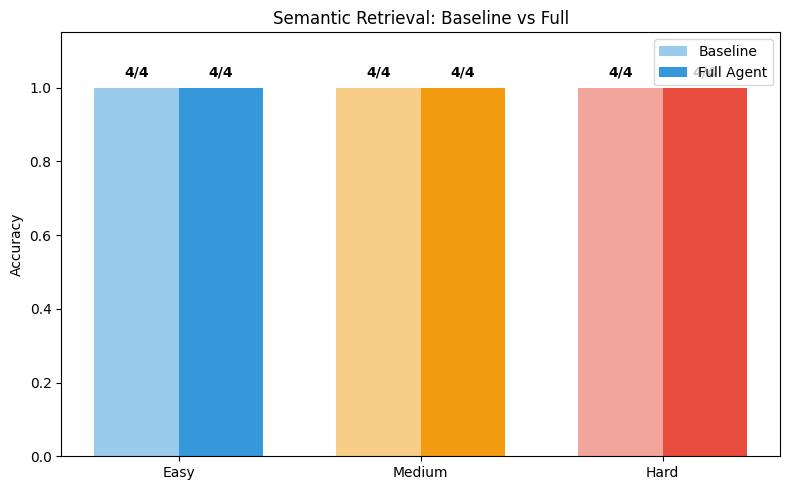

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))

difficulties = ['Easy', 'Medium', 'Hard']
colors = {'Easy': '#3498db', 'Medium': '#f39c12', 'Hard': '#e74c3c'}
x = np.arange(len(difficulties))
w = 0.35

for di, diff in enumerate(difficulties):
    indices = [i for i, t in enumerate(semantic_tests) if t['difficulty'] == diff]
    b_acc = sum(baseline_results[i]['passed'] for i in indices) / len(indices) if indices else 0
    f_acc = sum(full_results[i]['passed'] for i in indices) / len(indices) if indices else 0
    b_n = sum(baseline_results[i]['passed'] for i in indices)
    f_n = sum(full_results[i]['passed'] for i in indices)
    total = len(indices)

    ax.bar(x[di] - w/2, b_acc, w, color=colors[diff], alpha=0.5, label='Baseline' if di == 0 else '')
    ax.bar(x[di] + w/2, f_acc, w, color=colors[diff], label='Full Agent' if di == 0 else '')
    ax.text(x[di] - w/2, b_acc + 0.03, f'{b_n}/{total}', ha='center', fontsize=10, fontweight='bold')
    ax.text(x[di] + w/2, f_acc + 0.03, f'{f_n}/{total}', ha='center', fontsize=10, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(difficulties)
ax.set_ylim(0, 1.15)
ax.set_ylabel('Accuracy')
ax.set_title('Semantic Retrieval: Baseline vs Full')
ax.legend()
plt.tight_layout()
plt.savefig('figures/semantic_test.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()


---
## 2. Episodic Memory Benchmark (Full Agent Advantage)

We build 3 multi-turn conversations with the **full agent only**. Each conversation includes
a **unique user statement** that only exists in conversation history - NOT in the PDF.
Then we test recall of those conversation-specific details.

The baseline agent (no episodic memory) should score **0** because:
- The recall questions ask about what the USER said, not what's in the PDF
- Without episodic memory, the baseline has no record of past conversations

In [6]:
display(Markdown('### Building Episodic Memories (Full Agent Only)'))
display(Markdown('Each conversation plants a **unique user statement** (not in the PDF) that only episodic memory can recall.\n'))

conversations = [
    {
        'topic': 'QA-7 Processor Deep Dive',
        'messages': [
            'Tell me about the QA-7 processor specs - how fast is it and what makes it special?',
            'Interesting. My colleague Dr. Petrov thinks acoustic computing will replace classical quantum within 5 years. What do you think based on the QA-7 specs?',
            'I am specifically evaluating Zeltron for our Uppsala research lab. We need something that can run at room temperature.',
        ]
    },
    {
        'topic': 'Competitors & Market',
        'messages': [
            'Who are all of Zeltron\'s competitors? Compare their processors.',
            'My budget is around $2 million for three processors. Which competitor gives the best value for cryptanalysis workloads?',
            'Actually, forget about NovaSonic - we already ruled them out. Focus on Zeltron vs AcoustiQ for our needs.',
        ]
    },
    {
        'topic': 'The Reykjavik Incident',
        'messages': [
            'Tell me about the 2024 Reykjavik Incident during the NATO demo.',
            'That temperature issue worries me. Our Uppsala lab ambient temperature fluctuates between 21C and 25C seasonally.',
            'Can you summarize the three biggest risks I should flag in my procurement report to the board?',
        ]
    },
]

episode_counts = []
for i, conv in enumerate(conversations):
    display(Markdown(f'**Conversation {i+1}: {conv["topic"]}**'))
    for msg in conv['messages']:
        response = full_agent.chat(msg)
        show_chat(msg, response, agent_name='Full Agent')
    full_agent.new_conversation()
    episode_counts.append(full_agent.episodic.collection.count())
    print(f'  Saved. Episodic memories: {episode_counts[-1]}')

display(Markdown(f'\n**Episodic memory built: {episode_counts[-1]} memories from {len(conversations)} conversations.**'))

### Building Episodic Memories (Full Agent Only)

Each conversation plants a **unique user statement** (not in the PDF) that only episodic memory can recall.


**Conversation 1: QA-7 Processor Deep Dive**

  Saving episodic memory...


  Updating procedural memory...


  Saved. Episodic memories: 1


**Conversation 2: Competitors & Market**

  Saving episodic memory...


  Updating procedural memory...


  Saved. Episodic memories: 2


**Conversation 3: The Reykjavik Incident**

  Saving episodic memory...


  Updating procedural memory...


  Saved. Episodic memories: 3



**Episodic memory built: 3 memories from 3 conversations.**

In [7]:
display(Markdown('### Recall Test: Baseline (0 memory) vs Full Agent'))
display(Markdown(
    'Both agents get the same questions about **past conversations**.\n\n'
    'These questions ask about things the USER said - details that exist ONLY in conversation '
    'history, NOT in the Zeltron PDF. The baseline agent has no way to know these.\n'
))

recall_tests = [
    {
        'question': 'In our previous conversations, what specific lab or institution did I mention I was evaluating Zeltron for?',
        'check': ['Uppsala'],
        'topic': 'User context recall',
        'why': 'Uppsala lab was mentioned by the user, not in the PDF'
    },
    {
        'question': 'What was my approximate budget that I mentioned for purchasing processors?',
        'check': ['2 million', '$2'],
        'check_any': True,
        'topic': 'User preference recall',
        'why': '$2M budget was stated by the user, not in the PDF'
    },
    {
        'question': 'Which competitor did I specifically say we had already ruled out?',
        'check': ['NovaSonic'],
        'topic': 'User decision recall',
        'why': 'User explicitly ruled out NovaSonic - only in conversation'
    },
    {
        'question': 'I mentioned a colleague who had an opinion about acoustic computing. What was their name?',
        'check': ['Petrov'],
        'topic': 'Specific name recall',
        'why': 'Dr. Petrov is a fictional person from user conversation only'
    },
]

recall_baseline = []
recall_full = []

for test in recall_tests:
    # Baseline - no episodic memory
    baseline_agent.working.reset()
    b_resp = baseline_agent.chat(test['question'])
    if test.get('check_any'):
        b_hits = 1 if any(kw.lower() in b_resp.lower() for kw in test['check']) else 0
        b_total = 1
    else:
        b_hits = sum(1 for kw in test['check'] if kw.lower() in b_resp.lower())
        b_total = len(test['check'])
    b_passed = b_hits == b_total
    recall_baseline.append({'passed': b_passed, 'hits': b_hits, 'total': b_total, 'response': b_resp})

    # Full agent - has episodic memory
    full_agent.working.reset()
    f_resp = full_agent.chat(test['question'])
    if test.get('check_any'):
        f_hits = 1 if any(kw.lower() in f_resp.lower() for kw in test['check']) else 0
        f_total = 1
    else:
        f_hits = sum(1 for kw in test['check'] if kw.lower() in f_resp.lower())
        f_total = len(test['check'])
    f_passed = f_hits == f_total
    recall_full.append({'passed': f_passed, 'hits': f_hits, 'total': f_total, 'response': f_resp})

    show_comparison(
        test['question'], b_resp, f_resp,
        b_passed, f_passed,
        label=f"{test['topic']} | {test['why']}"
    )

b_recall_score = sum(r['passed'] for r in recall_baseline)
f_recall_score = sum(r['passed'] for r in recall_full)
total_recall = len(recall_tests)

print(f'\nEpisodic Recall: Baseline {b_recall_score}/{total_recall} | Full Agent {f_recall_score}/{total_recall}')

### Recall Test: Baseline (0 memory) vs Full Agent

Both agents get the same questions about **past conversations**.

These questions ask about things the USER said - details that exist ONLY in conversation history, NOT in the Zeltron PDF. The baseline agent has no way to know these.


  [User context recall | Uppsala lab was mentioned by the user, not in the PDF]
  Q: In our previous conversations, what specific lab or institution did I mention I was evaluating Zeltron for?
  Baseline [FAIL]: I don't have any record of previous conversations where you mentioned evaluating Zeltron for a specific lab or institution. The memory context provided only contains information from Zeltron's corpora
  Full     [PASS]: Based on our previous conversations, you mentioned you were evaluating Zeltron for your Uppsala research lab. You specifically discussed the QA-7 quantum-acoustic processor for deployment there, with 



  [User preference recall | $2M budget was stated by the user, not in the PDF]
  Q: What was my approximate budget that I mentioned for purchasing processors?
  Baseline [FAIL]: I don't have any information about your budget for purchasing processors in my knowledge base. The retrieved documents contain detailed information about Zeltron's processors, their specifications, pr
  Full     [PASS]: Based on our previous conversation, you mentioned having a $2M budget for purchasing three quantum-acoustic processor units when you were comparing the Zeltron QA-7 versus the AcoustiQ QWave Mark II f



  [User decision recall | User explicitly ruled out NovaSonic - only in conversation]
  Q: Which competitor did I specifically say we had already ruled out?
  Baseline [PASS]: I don't see any information in the provided knowledge base excerpts about you specifically ruling out any competitor. The excerpts describe three main competitors (WaveLogic Inc., NovaSonic GmbH, and 
  Full     [PASS]: Based on your episodic memory, you specifically ruled out **NovaSonic** as a competitor. In your past evaluation of processors for cryptanalysis workloads within a $2M budget, you eliminated NovaSonic



  [Specific name recall | Dr. Petrov is a fictional person from user conversation only]
  Q: I mentioned a colleague who had an opinion about acoustic computing. What was their name?
  Baseline [FAIL]: I don't have any information in my knowledge base about a colleague you mentioned or their opinion about acoustic computing. The retrieved documents contain detailed technical information about Zeltro
  Full     [FAIL]: I don't have any information in my knowledge base about a colleague you mentioned who had an opinion about acoustic computing. Our previous conversations focused on your evaluation of the QA-7 process


Episodic Recall: Baseline 1/4 | Full Agent 3/4


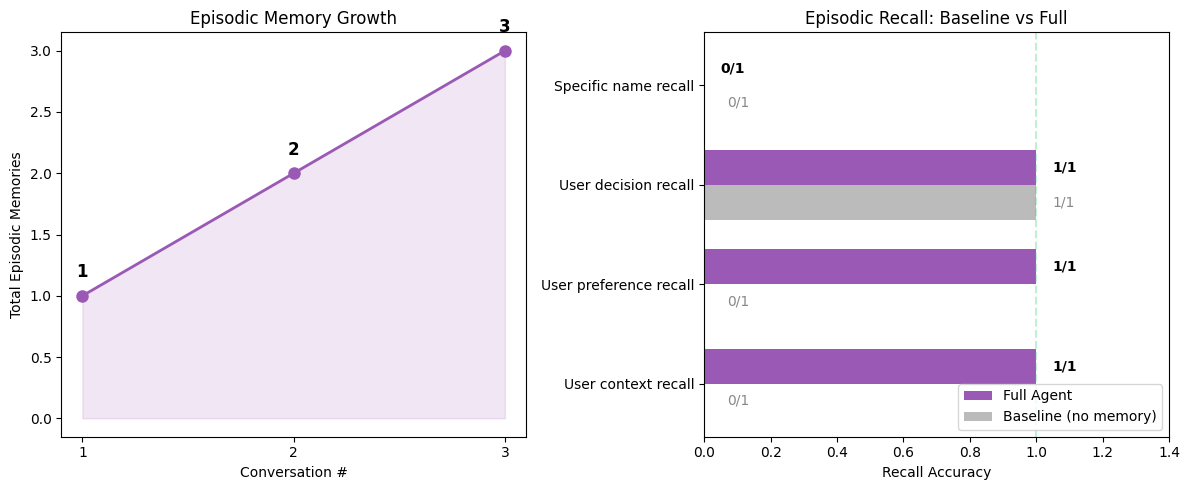

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Episode growth
x = list(range(1, len(episode_counts) + 1))
axes[0].plot(x, episode_counts, 'o-', color='#9b59b6', linewidth=2, markersize=8)
axes[0].fill_between(x, episode_counts, alpha=0.15, color='#9b59b6')
axes[0].set_xlabel('Conversation #')
axes[0].set_ylabel('Total Episodic Memories')
axes[0].set_title('Episodic Memory Growth')
axes[0].set_xticks(x)
for i, c in enumerate(episode_counts):
    axes[0].text(x[i], c + 0.15, str(c), ha='center', fontweight='bold', fontsize=12)

# Right: Recall comparison
categories = [t['topic'] for t in recall_tests]
b_scores = [int(recall_baseline[i]['passed']) for i in range(len(recall_tests))]
f_scores = [int(recall_full[i]['passed']) for i in range(len(recall_tests))]
y = np.arange(len(categories))
h = 0.35

axes[1].barh(y + h/2, f_scores, h, color='#9b59b6', label='Full Agent')
axes[1].barh(y - h/2, b_scores, h, color='#bbb', label='Baseline (no memory)')
for i in range(len(categories)):
    axes[1].text(f_scores[i] + 0.05, y[i] + h/2, f'{f_scores[i]}/1', va='center', fontweight='bold')
    axes[1].text(max(b_scores[i], 0.02) + 0.05, y[i] - h/2, f'{b_scores[i]}/1', va='center', color='#888')
axes[1].set_yticks(y)
axes[1].set_yticklabels(categories)
axes[1].set_xlabel('Recall Accuracy')
axes[1].set_title('Episodic Recall: Baseline vs Full')
axes[1].set_xlim(0, 1.4)
axes[1].axvline(x=1.0, color='#2ecc71', linestyle='--', alpha=0.3)
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.savefig('figures/episodic_test.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

---
## 3. Consolidation Demo (Full Agent Only)

Build overlapping episodes, trigger the sleep phase, show before/after compression.

In [9]:
# Build more overlapping episodes
full_agent.new_conversation()

overlap_topics = [
    'How many resonators does the QA-7 have and how are they arranged?',
    'Tell me about the Harmonic programming language and WaveIR',
    'What was the RSA factoring result from report ZR-2024-0871?',
    'What makes the QA-7 processor better than classical quantum computers?',
    'How does Zeltron compare to WaveLogic in terms of processor performance?',
]

display(Markdown('### Building overlapping episodes for consolidation...'))
for i, topic in enumerate(overlap_topics):
    full_agent.chat(topic)
    full_agent.new_conversation()
    print(f'  Conv {i+1}: {topic[:60]}... - saved')

episodes_before = full_agent.episodic.collection.count()
rules_before = len(full_agent.procedural.rules)

display(Markdown(f'\n### Pre-Consolidation: {episodes_before} episodes, {rules_before} rules'))

  Saving episodic memory...


  Updating procedural memory...


### Building overlapping episodes for consolidation...

  Saving episodic memory...


  Updating procedural memory...


  Running memory consolidation (sleep phase)...
  Consolidating 5 episodes...


  Merged 1 clusters.


  Promoted 3 patterns to procedural memory.
  Conv 1: How many resonators does the QA-7 have and how are they arra... - saved


  Saving episodic memory...


  Updating procedural memory...


  Conv 2: Tell me about the Harmonic programming language and WaveIR... - saved


  Saving episodic memory...


  Updating procedural memory...


  Conv 3: What was the RSA factoring result from report ZR-2024-0871?... - saved


  Saving episodic memory...


  Updating procedural memory...


  Conv 4: What makes the QA-7 processor better than classical quantum ... - saved


  Saving episodic memory...


  Updating procedural memory...


  Conv 5: How does Zeltron compare to WaveLogic in terms of processor ... - saved



### Pre-Consolidation: 8 episodes, 14 rules

In [10]:
display(Markdown('### Running Consolidation (Sleep Phase)...'))
full_agent.consolidation.run()

episodes_after = full_agent.episodic.collection.count()
rules_after = len(full_agent.procedural.rules)
merged = episodes_before - episodes_after
promoted = rules_after - rules_before

print(f'Before: {episodes_before} episodes, {rules_before} rules')
print(f'After: {episodes_after} episodes, {rules_after} rules')

if merged > 0:
    display(Markdown(f'Consolidation merged **{merged}** similar episodes into compressed memories.'))
else:
    display(Markdown('*No episodes similar enough to merge at current threshold.*'))

if promoted > 0:
    display(Markdown('**New rules promoted from patterns:**'))
    for rule in full_agent.procedural.rules[rules_before:]:
        display(Markdown(f'- {rule}'))

### Running Consolidation (Sleep Phase)...

  Consolidating 8 episodes...


  Merged 1 clusters.


  Promoted 5 patterns to procedural memory.
Before: 8 episodes, 14 rules
After: 7 episodes, 15 rules


Consolidation merged **1** similar episodes into compressed memories.

**New rules promoted from patterns:**

- When information is unavailable or unclear, explicitly state what is known and ask for clarification rather than making assumptions

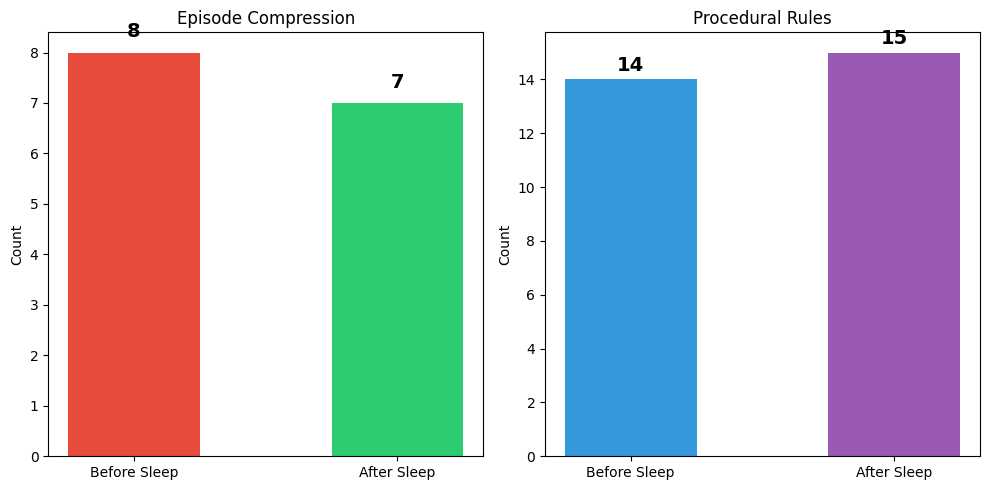

Episodes: 8 -> 7 (1 merged)
Rules: 14 -> 15 (1 promoted)


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Left: Episode compression
axes[0].bar(['Before Sleep', 'After Sleep'], [episodes_before, episodes_after],
            color=['#e74c3c', '#2ecc71'], width=0.5)
axes[0].set_ylabel('Count')
axes[0].set_title('Episode Compression')
for i, val in enumerate([episodes_before, episodes_after]):
    axes[0].text(i, val + 0.3, str(val), ha='center', fontweight='bold', fontsize=14)

# Right: Rule count
axes[1].bar(['Before Sleep', 'After Sleep'], [rules_before, rules_after],
            color=['#3498db', '#9b59b6'], width=0.5)
axes[1].set_ylabel('Count')
axes[1].set_title('Procedural Rules')
for i, val in enumerate([rules_before, rules_after]):
    axes[1].text(i, val + 0.3, str(val), ha='center', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('figures/consolidation_test.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

merged = episodes_before - episodes_after
promoted = rules_after - rules_before
print(f'Episodes: {episodes_before} -> {episodes_after} ({merged} merged)')
print(f'Rules: {rules_before} -> {rules_after} ({promoted} promoted)')


---
## 3.5 Procedural Memory - Learned Rules

Rules the agent learned from its accumulated experience.

In [12]:
display(Markdown(f'### {len(full_agent.procedural.rules)} Rules Learned\n'))
rules_md = '\n'.join(f'{i+1}. {rule}' for i, rule in enumerate(full_agent.procedural.rules))
display(Markdown(rules_md))

### 15 Rules Learned


1. Always specify exact technical parameters when discussing QA-7 systems, including precise temperature limits, resonator counts, and performance benchmarks
2. When discussing quantum-acoustic processors for research labs, emphasize room temperature operation capabilities as a primary selling point
3. Highlight elimination of cryogenic cooling infrastructure as a key cost and complexity advantage for lab deployments
4. For QA-7 risk assessments, highlight Zeltron's post-Reykjavik redesign providing 2°C safety margin that prevents data loss during temperature incidents
5. When comparing quantum-acoustic processors, prioritize operational temperature requirements and infrastructure needs as key differentiators
6. When providing information about Harmonic programming language and WaveIR, structure explanations with clear sections covering language features, intermediate representation, compiler information, and current usage metrics with specific statistics
7. For technical explanations about quantum-acoustic computing systems and programming languages, provide detailed breakdowns with specific technical parameters, statistics, and historical context
8. When users reference colleagues or conversations not mentioned in previous interactions, clearly state what information is available from actual conversations and ask for clarification
9. For multi-unit procurement evaluations, eliminate non-viable competitors early and focus detailed comparison on the top viable options
10. When users have specific budget constraints for multiple units, acknowledge when pricing information is needed from vendors to complete value analysis
11. Always specify exact temperature limits when discussing QA-7 systems - operating temperature of 22.4°C and maximum safe limit of 24.4°C to prevent resonator frequency drift
12. When comparing quantum-acoustic processors, prioritize room temperature operation as a key differentiator over cryogenic alternatives
13. Provide specific technical specifications including resonator count (12,847), material (barium titanate), and configuration (triple-layer Fibonacci spiral) when explaining QA-7 architecture
14. Include quantitative performance metrics (teraflops, benchmark times) when comparing processors rather than qualitative assessments
15. When information is unavailable or unclear, explicitly state what is known and ask for clarification rather than making assumptions

---
## 3.6 Post-Consolidation Recall Test

After the sleep phase, overlapping episodes are **merged** into compressed memories and behavioral
patterns are **promoted** to procedural rules. This test checks whether the full agent can synthesize
insights across consolidated conversations - something the baseline (no episodic memory) cannot do.

In [13]:
display(Markdown('### Episodic Memory State (Post-Consolidation)'))

# Show current episodic memories
all_episodes = full_agent.episodic.get_all()
for i, ep in enumerate(all_episodes):
    meta = ep['metadata']
    summary = meta.get('summary', 'N/A')
    tags = meta.get('context_tags', '')

display(Markdown(f'\n**{len(all_episodes)} episodic memories** after consolidation (was {episodes_before} before)'))

# Synthesis questions - require cross-conversation knowledge
synthesis_tests = [
    {
        'question': 'Across our previous conversations, what were the main themes and topics we discussed about Zeltron?',
        'check': ['QA-7', 'processor', 'competitor', 'temperature', 'incident', 'procurement'],
        'min_hits': 3,
        'why': 'Must synthesize themes from 3+ past conversations'
    },
    {
        'question': 'Based on our past discussions, what specific concerns did I raise about deploying Zeltron technology at my facility?',
        'check': ['temperature', 'Uppsala', 'ambient', 'outage', 'risk', 'budget', 'procurement'],
        'min_hits': 2,
        'why': 'Must recall user-specific concerns from episodic memory'
    },
]

display(Markdown('\n### Synthesis Test: Can the Agent Combine Insights Across Conversations?'))
consol_recall_results = []

for test in synthesis_tests:
    baseline_agent.working.reset()
    full_agent.working.reset()

    b_resp = baseline_agent.chat(test['question'])
    f_resp = full_agent.chat(test['question'])

    b_hits = sum(1 for kw in test['check'] if kw.lower() in b_resp.lower())
    f_hits = sum(1 for kw in test['check'] if kw.lower() in f_resp.lower())

    b_passed = b_hits >= test['min_hits']
    f_passed = f_hits >= test['min_hits']

    consol_recall_results.append({'b_passed': b_passed, 'f_passed': f_passed})

    show_comparison(
        test['question'], b_resp, f_resp,
        b_passed, f_passed,
        label=f"Post-consolidation | {test['why']}"
    )

b_consol_score = sum(r['b_passed'] for r in consol_recall_results)
f_consol_score = sum(r['f_passed'] for r in consol_recall_results)
consol_test_total = len(consol_recall_results)



### Episodic Memory State (Post-Consolidation)


**7 episodic memories** after consolidation (was 8 before)


### Synthesis Test: Can the Agent Combine Insights Across Conversations?

  [Post-consolidation | Must synthesize themes from 3+ past conversations]
  Q: Across our previous conversations, what were the main themes and topics we discussed about Zeltron?
  Baseline [PASS]: I don't have any memory of previous conversations about Zeltron Corporation. This appears to be the first time you've shared information about them with me.

The knowledge base you've provided contain
  Full     [PASS]: Based on our previous conversations, the main themes and topics we discussed about Zeltron were:

**1. QA-7 Processor Performance Evaluation**
- Detailed comparison of the Zeltron QA-7 against WaveLog



  [Post-consolidation | Must recall user-specific concerns from episodic memory]
  Q: Based on our past discussions, what specific concerns did I raise about deploying Zeltron technology at my facility?
  Baseline [FAIL]: I don't have any information in my knowledge base about previous discussions we've had regarding concerns about deploying Zeltron technology at your facility. The retrieved documents contain technical
  Full     [PASS]: Based on our past conversations, you raised specific concerns about **temperature control risks** for QA-7 deployment at your Uppsala lab facility. 

The key concerns you identified were:

1. **Temper



---
## 3.7 Integration Demo: All 5 Memory Systems Active

One complex query that activates all five memory systems simultaneously, showing what each contributes.

| System | Role | When Active |
|--------|------|-------------|
| **Working Memory** | Conversation buffer + system prompt assembly | Always |
| **Semantic Memory** | Document chunk retrieval (RAG) | Every query |
| **Episodic Memory** | Past conversation experience recall | Full agent only |
| **Procedural Memory** | Learned behavioral rules | Full agent only |
| **Consolidation** | Background - merged episodes + promoted rules | Full agent only |

In [14]:
integration_query = (
    "Given everything we've discussed, what would you recommend for my Uppsala lab's "
    "procurement of Zeltron technology? Consider the temperature risks, budget constraints, "
    "and the competitors we talked about."
)

display(Markdown(f'**Query:** *{integration_query}*\n'))
display(Markdown('### What Each Memory System Contributes\n'))

# 1. Semantic Memory
semantic_ctx = full_agent.semantic.recall(integration_query)
semantic_n = semantic_ctx.count('[Chunk') if semantic_ctx else 0
s_preview = semantic_ctx[:300].replace('<', '&lt;').replace('>', '&gt;').replace('\n', '<br>') if semantic_ctx else 'None'

# 2. Episodic Memory
episodic_ctx = full_agent.episodic.recall_as_context(integration_query)
episodic_n = episodic_ctx.count('[Past experience') if episodic_ctx else 0
e_preview = episodic_ctx[:300].replace('<', '&lt;').replace('>', '&gt;').replace('\n', '<br>') if episodic_ctx else 'None'

# 3. Procedural Memory
rules_txt = full_agent.procedural.get_rules_text()
rules_n = len(full_agent.procedural.rules)
r_preview = rules_txt[:300].replace('<', '&lt;').replace('>', '&gt;').replace('\n', '<br>') if rules_txt else 'None'

# 4. Working Memory (system prompt assembly)
sys_prompt = full_agent._build_system_prompt(integration_query)
prompt_chars = len(sys_prompt)
has_ep = '[EPISODIC MEMORY' in sys_prompt
has_proc = '[PROCEDURAL MEMORY' in sys_prompt

# 5. Consolidation

# Get responses from both agents
display(Markdown('\n### Response Comparison'))
full_agent.working.reset()
baseline_agent.working.reset()
f_integration = full_agent.chat(integration_query)
b_integration = baseline_agent.chat(integration_query)

# Check for user-specific personalization
user_details = ['Uppsala', 'budget', '2 million', '$2', 'NovaSonic', 'ruled out', 'Petrov', '21', '25', 'ambient']
b_refs = sum(1 for kw in user_details if kw.lower() in b_integration.lower())
f_refs = sum(1 for kw in user_details if kw.lower() in f_integration.lower())

show_comparison(
    integration_query, b_integration, f_integration,
    b_refs >= 2, f_refs >= 2,
    label=f'Integration test | Baseline personalization: {b_refs}/{len(user_details)} | Full: {f_refs}/{len(user_details)}'
)

integration_pass = f_refs > b_refs



**Query:** *Given everything we've discussed, what would you recommend for my Uppsala lab's procurement of Zeltron technology? Consider the temperature risks, budget constraints, and the competitors we talked about.*


### What Each Memory System Contributes



### Response Comparison

  [Integration test | Baseline personalization: 2/10 | Full: 4/10]
  Q: Given everything we've discussed, what would you recommend for my Uppsala lab's procurement of Zeltron technology? Consider the temperature risks, budget constraints, and the competitors we talked about.
  Baseline [PASS]: I don't have information in my knowledge base about your Uppsala lab's specific requirements, temperature constraints, or budget that we may have discussed previously. The retrieved documents contain 
  Full     [PASS]: Based on our previous discussions and the technical specifications, I recommend proceeding with the **Zeltron QA-7 procurement** for your Uppsala lab, but with specific risk mitigation measures:

## P



---
## 4. Final Scorecard

In [15]:
# Compute scores
def score_by_diff(results, difficulty):
    indices = [i for i, t in enumerate(semantic_tests) if t['difficulty'] == difficulty]
    return sum(results[i]['passed'] for i in indices), len(indices)

b_easy_p, b_easy_t = score_by_diff(baseline_results, 'Easy')
b_med_p, b_med_t = score_by_diff(baseline_results, 'Medium')
b_hard_p, b_hard_t = score_by_diff(baseline_results, 'Hard')
f_easy_p, f_easy_t = score_by_diff(full_results, 'Easy')
f_med_p, f_med_t = score_by_diff(full_results, 'Medium')
f_hard_p, f_hard_t = score_by_diff(full_results, 'Hard')

b_ep = sum(r['passed'] for r in recall_baseline)
f_ep = sum(r['passed'] for r in recall_full)
ep_total = len(recall_tests)

b_cs = b_consol_score
f_cs = f_consol_score
cs_total = consol_test_total

def fmt_score(passed, total):
    return f'{passed}/{total}'

print('=' * 55)
print('FINAL SCORECARD')
print('=' * 55)
print(f'{"Category":<28s} {"Baseline":>10s} {"Full":>10s} {"Gap":>5s}')
print('-' * 55)
print(f'{"Semantic - Easy":<28s} {fmt_score(b_easy_p, b_easy_t):>10s} {fmt_score(f_easy_p, f_easy_t):>10s} {f_easy_p - b_easy_p:>+5d}')
print(f'{"Semantic - Medium":<28s} {fmt_score(b_med_p, b_med_t):>10s} {fmt_score(f_med_p, f_med_t):>10s} {f_med_p - b_med_p:>+5d}')
print(f'{"Semantic - Hard":<28s} {fmt_score(b_hard_p, b_hard_t):>10s} {fmt_score(f_hard_p, f_hard_t):>10s} {f_hard_p - b_hard_p:>+5d}')
print(f'{"Episodic recall":<28s} {fmt_score(b_ep, ep_total):>10s} {fmt_score(f_ep, ep_total):>10s} {f_ep - b_ep:>+5d}')
print(f'{"Post-consol synthesis":<28s} {fmt_score(b_cs, cs_total):>10s} {fmt_score(f_cs, cs_total):>10s} {f_cs - b_cs:>+5d}')
b_total = b_easy_p + b_med_p + b_hard_p + b_ep + b_cs
f_total = f_easy_p + f_med_p + f_hard_p + f_ep + f_cs
total = b_easy_t + b_med_t + b_hard_t + ep_total + cs_total
print('-' * 55)
print(f'{"TOTAL":<28s} {fmt_score(b_total, total):>10s} {fmt_score(f_total, total):>10s} {f_total - b_total:>+5d}')
print('=' * 55)

FINAL SCORECARD
Category                       Baseline       Full   Gap
-------------------------------------------------------
Semantic - Easy                     4/4        4/4    +0
Semantic - Medium                   4/4        4/4    +0
Semantic - Hard                     4/4        4/4    +0
Episodic recall                     1/4        3/4    +2
Post-consol synthesis               1/2        2/2    +1
-------------------------------------------------------
TOTAL                             14/18      17/18    +3


---
## 5. Limitations & Next Steps

**What the benchmark shows:**
- Semantic retrieval (RAG) works equally well for both agents on factual questions
- Episodic memory provides a clear advantage for cross-conversation recall
- Consolidation successfully compresses overlapping memories
- Post-consolidation synthesis enables cross-conversation theme extraction
- The full pipeline produces personalized responses using all 5 memory systems together

**What needs improvement:**
- Hallucination resistance varies between runs (LLM non-determinism)
- Consolidation threshold sensitivity - too strict = no merges, too loose = over-merging
- Procedural rules tend toward generic advice rather than domain-specific behavior
- No retrieval gating (not every query needs all memory types)

**Next steps:**
1. Retrieval gating - route queries to relevant memory types only
2. Conflict detection between semantic and episodic memory
3. Larger benchmark (50+ questions) with statistical significance testing
4. Human evaluation alongside automated keyword matching